# Imports

In [1]:
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from dotenv import load_dotenv
from sqlalchemy import create_engine, MetaData, Table
from sklearn.model_selection import train_test_split

load_dotenv(override=True)

True

# Carregando dados

Carregando as variáveis ambientes

In [2]:
DB_USER = os.getenv("DB_USER")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_DATABASE = os.getenv("DB_DATABASE")

engine = create_engine(f"mysql+pymysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_DATABASE}")

Visualizando as tabelas

In [3]:
# Cria o objeto metadata
metadata = MetaData()

# Reflete (carrega) todas as tabelas do banco
metadata.reflect(bind=engine)

# Lista os nomes das tabelas
print(metadata.tables.keys())

dict_keys(['daumau', 'desinstalacoes', 'installs', 'ratings_reviews'])


Carregando as tabelas

In [4]:
#carregando tabelas

with engine.connect() as connection:
    df_daumau = pd.read_sql(
        sql = "SELECT * FROM case_data_scientist.daumau",
        con = connection
    )
    df_desinstalacoes = pd.read_sql(
        sql = "SELECT * FROM case_data_scientist.desinstalacoes",
        con = connection
    )
    df_instalacoes = pd.read_sql(
        sql = "SELECT * FROM case_data_scientist.installs",
        con = connection
    )
    df_reviews = pd.read_sql(
        sql = "SELECT * FROM case_data_scientist.ratings_reviews",
        con = connection
    )

# Estudo das tabelas

O principal objetivo dessa etapa é entender quais as informações presentes na tabela e a sua usabilidade, com isso realizando os tratamentos necessários para juntar as bases em uma etapa seguinte

Realizari as seguintes analises para todas as bases:
- Verificação de **Tamanho da Base** : Entendo qual as dimensões das bases que serão trabalhadas.
- Verificação de **Tipagem** : Busco entender quais os tipos presentes e se há necessidade de tratamento no campo.
- Verificação de **Dados Ausentes**: Percebo como está o preenchimento do dado e os valores ausentes.
- Verificação de **Registros Duplicados**: Realizo a validação de registros dúplicados na base.

## daumau - Tabela de usuários ativos diariamente/mensalmente

Crio uma documentação com base no entendimento do dado

- **appId**: Chave unica de agrupamento do aplicativo
- **date**: Data de referência do registro
- **dauReal**: Número de usuários ativos no dia
- **mauReal**: Número de usuários ativos no mês

In [5]:
df_daumau.head()

,appId,date,dauReal,mauReal
0,com.app.33540,2024-01-01,393961.0,3643110.0
1,com.app.33540,2024-01-02,800448.0,3643040.0
2,com.app.31679,2024-01-01,157532.0,1349262.0
3,com.app.31679,2024-01-02,313847.0,1349317.0
4,com.app.77385,2024-01-01,239768.0,1934660.0


**Verificação de tamanho**

Busco entender as dimensões da base que estou trabalhando.

In [6]:
df_daumau.shape

(41299, 4)

**Verificação de tipagem**

Verificando os tipos das variaveis do dataset, verificando se há algum campo que precise de ajustes.

In [7]:
df_daumau.dtypes

appId       object
date        object
dauReal    float64
mauReal    float64
dtype: object

Observei acima que o formato da variável date estava como um objeto, porém alterei para date, pois em etapas seguintes irá facilitar para um estudo de safras e dominio do campo.

In [8]:
df_daumau["date"] = pd.to_datetime(df_daumau["date"])

**Verificação de dados duplicados**

Identifico que 153 registros estão completamente dúplicados na base

In [9]:
df_daumau.duplicated().sum()

153

Observo que os mesmos 153 registros estão dúplicados quando coloco as chaves de ID e data, corroborando para serem um comportamento que não deveria estar presente, resolvo remover os dados duplicados.

In [10]:
df_daumau.duplicated(subset=["appId", "date"]).sum()

153

In [11]:
df_daumau = df_daumau.drop_duplicates()

**Verificação de dados nulos**

Há presença de valores nulos nos campos appId, dauReal e mauReal, realizei os seguintes tratamentos:
- **appId**: chave primaria, como não havia a possibilidade de juntar somente pelo campo date por conta de duplicação, foi necessário remover para que seja possivel juntar as tabelas.
- **mauReal**:  Verifiquei qual a relação dos valores NAs desse campo com os demais, e observei que havia apenas um appID com esse comportamento, e como não era possivel reconstruir a partir do campo dauReal, decidi remover.
- **dauReal**: Defini os valor nulos por 0, uma vez que o número de acessos no mês estava com valores preenchidos, assumindo que apenas não houve acesso naquele mês.


In [12]:
df_daumau.isna().sum()

appId       28
date         0
dauReal    194
mauReal     20
dtype: int64

In [13]:
df_daumau[df_daumau['appId'].isna()]

,appId,date,dauReal,mauReal
41271,None,2220-07-21,3671.0,43502.0
41272,None,2220-07-22,11641.0,123719.0
41273,None,2220-07-23,29128.0,299245.0
41274,None,2220-07-24,300840.0,2012700.0
41275,None,2220-07-25,18678.0,184422.0
41276,None,2220-07-26,30026.0,155138.0
41277,None,2220-07-27,882066.0,2708497.0
41278,None,2220-07-28,31602.0,191683.0
41279,None,2220-07-29,374946.0,611578.0
41280,None,2220-07-30,15750.0,106200.0


In [14]:
df_daumau[df_daumau['mauReal'].isna()]

,appId,date,dauReal,mauReal
4989,com.app.90128,2024-01-12,37330.0,NaN
4990,com.app.90128,2024-01-13,41617.0,NaN
4991,com.app.90128,2024-01-14,44214.0,NaN
4992,com.app.90128,2024-01-15,35283.0,NaN
4993,com.app.90128,2024-01-16,33946.0,NaN
4994,com.app.90128,2024-01-17,33953.0,NaN
4995,com.app.90128,2024-01-18,33183.0,NaN
4996,com.app.90128,2024-01-19,37418.0,NaN
4997,com.app.90128,2024-01-20,41012.0,NaN
4998,com.app.90128,2024-01-21,44668.0,NaN


In [15]:
df_daumau[~df_daumau['mauReal'].isna() & df_daumau['dauReal'].isna()]

,appId,date,dauReal,mauReal
3038,com.app.20651,2024-01-02,NaN,2266.0
3039,com.app.20651,2024-01-04,NaN,2234.0
3040,com.app.20651,2024-01-05,NaN,2326.0
3041,com.app.20651,2024-01-07,NaN,2257.0
3042,com.app.20651,2024-01-08,NaN,2266.0
...,...,...,...,...
24072,com.app.13071,2024-06-04,NaN,2688.0
24073,com.app.13071,2024-06-05,NaN,2695.0
24074,com.app.13071,2024-06-06,NaN,2675.0
24075,com.app.13071,2024-06-07,NaN,2632.0


In [16]:
df_daumau = df_daumau.dropna(subset=['appId','mauReal'], how='any')
df_daumau['dauReal'] = df_daumau['dauReal'].fillna(0)

## Desinstalações - Tabela com informações referente a desinstalações

- **country** país em que o app é utilizado
- **lang** lingua/idioma do país onde o app é utilizado
- **predictionLoss**:

In [17]:
df_desinstalacoes.head()

,appId,date,country,lang,predictionLoss
0,com.app.71740,2024-01-01,br,pt,1463
1,com.app.33540,2024-01-01,br,pt,8170
2,com.app.19544,2024-01-01,br,pt,77048
3,com.app.77385,2024-01-01,br,pt,4497
4,com.app.31679,2024-01-01,br,pt,4287


**Verificação de tamanho**

Busco entender as dimensões da base que estou trabalhando.

In [18]:
df_desinstalacoes.shape

(53188, 5)

**Verificação de tipagem**

Verificando os tipos das variaveis do dataset, verificando se há algum campo que precise de ajustes.

In [19]:
df_desinstalacoes.dtypes

appId                     object
date              datetime64[ns]
country                   object
lang                      object
predictionLoss             int64
dtype: object

**Verificação de dados duplicados**

Não há dados duplicados que possam ser problema

In [20]:
df_desinstalacoes.duplicated().sum()

0

**Verificação de dados nulos**

Não há presença de valores NAs, não havendo necessidade de ajustes

In [21]:
df_daumau.isna().sum()

appId      0
date       0
dauReal    0
mauReal    0
dtype: int64

## Instalações - Tabela com informações de instalações realizadas

Crio uma documentação com base no entendimento do dado

- **appId**: Chave unica de agrupamento do aplicativo
- **date**: Data de referência do registro
- **newinstalls**: Número de instalações na data de referência

In [22]:
df_instalacoes.head()

,appid,date,newinstalls
0,com.app.86367,2024-01-01,1968
1,com.app.18711,2024-01-01,1364
2,com.app.36257,2024-01-01,7511
3,com.app.88509,2024-01-01,53137
4,com.app.93131,2024-01-01,137


**Verificação de tamanho**

In [23]:
df_instalacoes.shape

(48150, 3)

**Verificação de tipagem**

In [24]:
df_instalacoes.dtypes

appid                  object
date           datetime64[ns]
newinstalls             int64
dtype: object

**Verificação de dados duplicados**

In [25]:
df_daumau.duplicated().sum()

0

**Verificação de dados nulos**

In [26]:
df_daumau.isna().sum()

appId      0
date       0
dauReal    0
mauReal    0
dtype: int64

## Reviews - Tabela com informações de rating e reviews

Crio uma documentação com base no entendimento do dado

- **category**: Categoria de segmento de mercado do aplicativo
- **ratings**: Quantidade notas acumuladas do aplicativo
- **daily_ratings**: Quantidade de notas na data de referência
- **reviews**: Quantidade de avaliações acumuladas do aplicativo
- **daily_reviews**: Quantidade de avaliações na data de referência

In [27]:
df_reviews.head()

,date,appid,category,ratings,daily_ratings,reviews,daily_reviews
0,2024-01-01,com.app.40009,OTHERS,63500.0,5.0,25251.0,0.0
1,2024-01-01,com.app.88516,OTHERS,2440.0,0.0,312.0,0.0
2,2024-01-01,com.app.64634,TRAVEL_AND_LOCAL,536.0,0.0,331.0,0.0
3,2024-01-01,com.app.78470,SHOPPING,97924.0,7.0,27241.0,23.0
4,2024-01-01,com.app.36433,FINANCE,678.0,0.0,414.0,0.0


**Verificação de tamanho**

In [28]:
df_reviews.shape

(47155, 7)

**Verificação de tipagem**

In [29]:
df_reviews.dtypes

date              object
appid             object
category          object
ratings          float64
daily_ratings    float64
reviews          float64
daily_reviews    float64
dtype: object

In [30]:
df_reviews["date"] = pd.to_datetime(df_reviews["date"])

**Verificação de dados duplicados**

In [31]:
df_reviews.duplicated().sum()

0

**Verificação de dados nulos**

In [32]:
df_reviews.isna().sum()

date             0
appid            0
category         0
ratings          0
daily_ratings    0
reviews          0
daily_reviews    0
dtype: int64

# Analisando bases agrupadas

Após os tratamentos iniciais, realizo o agrupamento das bases e avanço no processo de analise dos campos, através de analise individual dos campos e em conjunto.

In [33]:
df_instalacoes = df_instalacoes.rename(columns={"appid": "appId"})
df_reviews = df_reviews.rename(columns = {"appid": "appId"})

df_completo = (
    df_daumau
    .merge(df_desinstalacoes, how='left', on=['appId', 'date'])
    .merge(df_instalacoes, how='left', on=['appId', 'date'])
    .merge(df_reviews, how='left', on=['appId', 'date'])
)

Removo as colunas ***lang*** e ***country*** pois possuem apenas os valores categóricos **pt** e **br**, o que não agregariam valor nesse nosso cenário.

A base apresentou alguns valores nulos, o único campo que seria possivel corrigir seria a ***category*** pois é o único campo de carater categorico, pude observar que os aplicativos se enquadram em apenas um, então quando há informação em outras safras podemos preencher o mesmo valor.

In [34]:
df_completo = df_completo.drop(
    columns = ["lang","country"]
)

In [35]:
df_completo.isna().sum()

appId                0
date                 0
dauReal              0
mauReal              0
predictionLoss     200
newinstalls       2722
category          2283
ratings           2283
daily_ratings     2283
reviews           2283
daily_reviews     2283
dtype: int64

In [36]:
df_completo[(df_completo['category'].isna())]

,appId,date,dauReal,mauReal,predictionLoss,newinstalls,category,ratings,daily_ratings,reviews,daily_reviews
8,com.app.85381,2024-01-01,1006.0,24799.0,1786.0,NaN,NaN,NaN,NaN,NaN,NaN
9,com.app.85381,2024-01-02,1624.0,24862.0,1787.0,NaN,NaN,NaN,NaN,NaN,NaN
120,com.app.81778,2024-01-01,768.0,19994.0,1786.0,NaN,NaN,NaN,NaN,NaN,NaN
121,com.app.81778,2024-01-02,985.0,20035.0,1787.0,NaN,NaN,NaN,NaN,NaN,NaN
168,com.app.34216,2024-01-01,1729.0,38562.0,1786.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
41231,com.app.32607,2044-07-13,130203.0,578280.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41232,com.app.48189,2044-07-14,7412.0,36137.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41233,com.app.21603,2044-07-15,81544.0,854480.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41234,com.app.50760,2044-07-16,49957.0,173394.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
not_null_map = (
    df_completo.dropna(subset=['category'])
               .drop_duplicates(subset=['appId'])
               .set_index('appId')['category']
)
df_completo['category'] = df_completo['category'].fillna(df_completo['appId'].map(not_null_map))


## Análise Univariada

Analiso os campos individualmente para entender o comportamento e dominio de cada um, realizando assim os devidos tratamentos.

### *date*

Já havia observado em etapas anteriores a presença de outlliers para esse campo, então seleciono apenas a data de 2024, inicio por ele pois isso irá remover registros problematicos nas analises seguintes.

In [38]:
df_completo['year'] = pd.to_datetime(df_completo['date']).dt.year

In [39]:
df_completo['year'].value_counts()

year
2024    41163
2220       31
2044       17
1912       14
1980       11
Name: count, dtype: int64

In [40]:
df_completo = df_completo.loc[df_completo['year'] == 2024]

### *dauReal*

In [41]:
df_completo['dauReal'].describe().apply(lambda x: f"{x:,.2f}")

count        41,163.00
mean        438,272.46
std       1,333,702.92
min               0.00
25%           8,448.50
50%          30,701.00
75%         161,606.00
max      10,648,152.00
Name: dauReal, dtype: object

### *mauReal*

In [42]:
df_completo['mauReal'].describe().apply(lambda x: f"{x:,.2f}")

count        41,163.00
mean      1,913,490.33
std       4,788,045.11
min             750.00
25%          78,038.00
50%         231,243.00
75%         863,594.50
max      29,605,840.00
Name: mauReal, dtype: object

### *predictionLoss*

In [43]:
df_completo['predictionLoss'].describe().apply(lambda x: f"{x:,.2f}")

count     41,036.00
mean      12,505.77
std       23,786.15
min          455.00
25%        1,777.00
50%        3,947.00
75%        9,459.25
max      189,683.00
Name: predictionLoss, dtype: object

### *newinstalls*

In [44]:
df_completo['newinstalls'].describe().apply(lambda x: f"{x:,.2f}")

count    38,514.00
mean      4,018.60
std       8,348.40
min           0.00
25%         324.00
50%         948.00
75%       3,094.00
max      71,825.00
Name: newinstalls, dtype: object

### *category*

In [45]:
df_completo['category'].value_counts()

category
FINANCE             15774
OTHERS               9528
SHOPPING             7169
BUSINESS             3612
TRAVEL_AND_LOCAL     2595
FOOD_AND_DRINK       1337
Name: count, dtype: int64

### *ratings*

In [46]:
df_completo['ratings'].describe().apply(lambda x: f"{x:,.2f}")

count        38,953.00
mean        311,642.32
std         783,370.12
min              19.00
25%           9,404.00
50%          50,430.00
75%         208,503.00
max      13,214,326.00
Name: ratings, dtype: object

### *daily_ratings*

Rating diario negativo não parece fazer sentido, então removo o dado.

In [47]:
df_completo['daily_ratings'].describe().apply(lambda x: f"{x:,.2f}")

count    38,953.00
mean        147.60
std         396.48
min         -86.00
25%           2.00
50%          14.00
75%          83.00
max       6,353.00
Name: daily_ratings, dtype: object

In [48]:
df_completo = df_completo.loc[df_completo['daily_ratings'] >= 0]

### *reviews*

In [49]:
df_completo['reviews'].describe().apply(lambda x: f"{x:,.2f}")

count       38,541.00
mean        91,353.15
std        219,717.01
min             11.00
25%          3,328.00
50%         15,626.00
75%         57,141.00
max      1,491,128.00
Name: reviews, dtype: object

### *daily_reviews*

Reviews diario negativo também não parece fazer sentido, então removo o dado.

In [50]:
df_completo['daily_reviews'].describe().apply(lambda x: f"{x:,.2f}")

count    38,541.00
mean         20.74
std          53.67
min         -19.00
25%           1.00
50%           3.00
75%          14.00
max       1,808.00
Name: daily_reviews, dtype: object

In [51]:
df_completo = df_completo.loc[df_completo['daily_reviews'] >= 0]

### *dauReal*

In [52]:
df_completo['dauReal'].describe().apply(lambda x: f"{x:,.2f}")

count        38,494.00
mean        462,144.11
std       1,365,144.80
min               0.00
25%          10,101.50
50%          35,546.50
75%         193,405.00
max      10,648,152.00
Name: dauReal, dtype: object

### *mauReal*

In [53]:
df_completo['mauReal'].describe().apply(lambda x: f"{x:,.2f}")

count        38,494.00
mean      2,027,516.10
std       4,909,133.88
min             766.00
25%          93,654.00
50%         289,892.00
75%       1,067,788.50
max      29,605,840.00
Name: mauReal, dtype: object

### *predictionLoss*

In [54]:
df_completo['predictionLoss'].describe().apply(lambda x: f"{x:,.2f}")

count     38,490.00
mean      13,063.06
std       24,290.59
min          455.00
25%        1,803.00
50%        4,216.00
75%        9,849.75
max      189,683.00
Name: predictionLoss, dtype: object

### *newinstalls*

In [55]:
df_completo['newinstalls'].describe().apply(lambda x: f"{x:,.2f}")

count    37,934.00
mean      4,036.77
std       8,362.73
min           0.00
25%         320.00
50%         942.00
75%       3,133.00
max      71,825.00
Name: newinstalls, dtype: object

### *category*

In [56]:
df_completo['category'].value_counts()

category
FINANCE             15165
OTHERS               9139
SHOPPING             6894
BUSINESS             3572
TRAVEL_AND_LOCAL     2583
FOOD_AND_DRINK       1141
Name: count, dtype: int64

## Análise Bivariada

Nessa seção busco correlações entre variáveis para começar a entender quais são mais explicativas para o fenômeno que buscamos modelar. 

Por se tratar de um número pequeno de variáveis, começo já utilizando a ***correlação de Pearson***.

Nesta etapa iremos entender melhor a relação das variáveis em questão, buscando entender quais conseguirão melhor explicar o modelo que estamos construindo.

Observamos que as features **ratings** e **reviews** possuem maior correlação com o número de usuários ativos, podendo indicar trazer ganhos interessantes no modelo.

In [57]:
df_numeric = df_completo.select_dtypes(include=["number"])

correlation_matrix = df_numeric.corr(method='pearson')

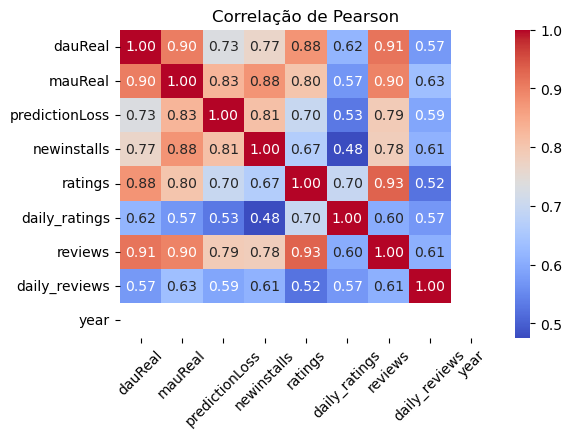

In [58]:
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.xticks(rotation=45)
plt.title("Correlação de Pearson")
plt.show()

# Preparando dados para Modelagem
Separei 10% da base para validação de performance, e o restante eu utilizarei no processo de modelagem.

In [59]:
df_completo = df_completo.sort_values(by=["appId", "date"])

df_train_val, df_test = train_test_split(
    df_completo,
    test_size=0.1,
    shuffle=False
)


In [ ]:
df_train_val.to_csv('../data/modeling_data.csv', index=False)
df_test.to_csv('../data/test_data.csv', index=False)